# 1. 소개
* 조명 - 치즈케이크
* 프로젝트명 - 
* 분석목적 - 최근 유행하는 치즈케이크 집의 분포를 알아보자

# 2. 조원소개와 역할 (사진포함)
* 김다영
* 김민기
* 서준영
* 이수진

# 3. 데이터 출처와 전처리 전의 데이터 구조 (테이블구조로 샘플수와 속성 설명 포함)
## (1) 데이터 수집 방법 : 크롤링
* 데이터 출처 : 인스타그램  
인스타그램에서 #치즈케이크 해시태그로 검색하여 최근 게시물 데이터를 확보했다.  
목표 샘플수는 10000개를 목표로 했으나, 인스타그램의 검색량 제한으로 중간에 멈췄다.  
따라서 크롤링 과정을 2단계로 나누어 네 명이서 크롤링을 분담하였다.  
특징: 위치 정보를 입력하지 않는 글은 저장되지 않는다

### 사전 환경 설정

In [2]:
from selenium import webdriver
from urllib.parse import quote
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd 
import re

#사전정보 입력
handle = '' #인스타그램 아이디
pwd = ''  #인스타그램 비밀번호

keyword= '치즈케이크'   #검색할 키워드
num_of_pages = 800 #몇 번 스크롤 할 건지; e.g. 200 --> 1730개 게시글 긁어짐
driver_dir = 'c:/Temp/chromedriver.exe'    #크롬드라이버 경로
k = 1 # k는 1~4로 각각 맡음

### RAW 데이터 수집

In [30]:
#1단계 : 검색 페이지에서 글 URL 가져오기
def InstagramUrlFromKeyword (browser,keyword,num_of_pagedowns):
    keyword_url_encode=quote(keyword)
    url='https://www.instagram.com/explore/tags/'+keyword+'/?hl=ko'
    browser.get(url)
    time.sleep(3)
    login = browser.find_element_by_xpath('//*[@id="react-root"]/section/nav/div[2]/div/div/div[3]/div/span/a[1]/button')
    login.click()
    time.sleep(3)
    user_id = browser.find_element_by_class_name('_2hvTZ.pexuQ.zyHYP')
    pw = browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/article/div/div[1]/div/form/div[3]/div/label/input')
    user_id.send_keys(handle)
    pw.send_keys(pwd)
    button = browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/article/div/div[1]/div/form/div[4]/button')
    button.click()
    time.sleep(3)
    arr_href=[]
    body=browser.find_element_by_tag_name('body')
    for i in range(num_of_pagedowns):
        body.send_keys(Keys.PAGE_DOWN)
        time.sleep(1)
        post=browser.find_elements_by_class_name('v1Nh3')
        for j in post:
            href_str=j.find_element_by_css_selector('a').get_attribute('href')
            arr_href.append(href_str)
    return set(arr_href)    

char = r'#[\d\w]+'
char2 = re.compile('[^ 0-9a-zA-Zㄱ-ㅣ가-힣!#?]')

#2단계 : URL 정보를 4명분으로 나누기
arr = list(arr)
text1 = arr[:threshold]
text2 = arr[threshold: 2*threshold]
text3 = arr[2*threshold: 3*threshold]
text4 = arr[3*threshold:]
texts = [text1, text2, text3, text4]

for k in range(len(texts)):
    with open('url_part' + str(k+1) + '.txt', 'w') as f:
        for url in texts[k]:
            f.write(url + '\n')


#3단계 : 글 URL에서 필요한 데이터 수집
def IdHashTagFromInstagram(browser,url):
    browser.get(url)
    datetime = browser.find_element_by_class_name('_1o9PC.Nzb55').get_attribute('title')
    href=browser.find_elements_by_class_name('C4VMK')
    #포스트 내용(글, 태그)
    total_hash_text=[]    
    for i in range(0, len(href)):
        hash_text= href[i].find_element_by_css_selector('span').text
        total_hash_text.append(hash_text)
    tags = re.findall(char, char2.sub(' ',str(total_hash_text)))
    user_name = browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/div/article/header/div[2]/div[1]/div[1]/h2/a').text
    like_count = int(browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/div/article/div[2]/section[2]/div/div/button/span').text)
    location = browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/div/article/header/div[2]/div[2]/div[2]/a').text
    loc_url = browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/div/article/header/div[2]/div[2]/div[2]/a').get_attribute('href')
    return datetime, user_name, like_count, tags, location, url, loc_url

#4단계 : 크롤링 시행
browser = webdriver.Chrome(driver_dir)
insta_df=pd.DataFrame(columns = {'Datetime', 'User_Name', 'Like_Count', 'Tags', 'Location','URL', 'Location_URL'})

with open('url_part' + str(k) + '.txt', 'r') as f:
    urls = f.readlines()
for url in urls:
    try:
        datetime, user_name, like_count, tags, location, url, loc_url = IdHashTagFromInstagram(browser, url.strip('\n'))
        insta_df = insta_df.append({'Datetime': datetime, 'User_Name':user_name, 'Like_Count':like_count,'Tags': tags, 'Location' : location, 'URL':url,'Location_URL' : loc_url}, ignore_index = True)
    except:
        continue

In [61]:
# 크롤링 후 네 개의 데이터 합치기
insta_df_part1 = pd.read_csv('testtesttest1.csv', index_col=0, encoding='UTF-8')
insta_df_part2 = pd.read_csv('testtesttest2.csv', index_col=0, encoding='UTF-8')
insta_df_part3 = pd.read_csv('testtesttest3.csv', index_col=0, encoding='UTF-8')
insta_df_part4 = pd.read_csv('testtesttest4.csv', index_col=0, encoding='UTF-8')
insta_df_parts = pd.concat([insta_df_part1,insta_df_part2,insta_df_part3,insta_df_part4], sort=False)

#### 크롤링 결과 수집된 데이터를 csv로 저장
euc-kr로 저장하면 인코딩 문제로 오류나서 utf-8로 저장함

In [72]:
insta_df_parts.to_csv('rawdata_final.csv',mode='w', encoding='UTF-8')

#### 크롤링 완료 후 데이터가 잘 수집되었는지 확인

In [70]:
len(insta_df_final)

3159

## (2) 전처리 전의 데이터 구조
* 샘플수 3159개
* 수집 항목 : 작성날짜, 해시태그, 좋아요 수, 위치, 사용자 아이디, 지도url


In [71]:
insta_df_final[:10]

,Location_URL,Tags,User_Name,Location,Like_Count,URL,Datetime
0,https://www.instagram.com/explore/locations/37...,"['#고소함', '#흑임자', '#치즈케이크', '#할매입맛', '#크리스마스', ...",gosop_gosop,정자동 카페거리,37,https://www.instagram.com/p/B6ZmDGPnAsk/,2019년 12월 23일
1,https://www.instagram.com/explore/locations/10...,"['#달콤수다', '#데이트', '#이쁜그녀들', '#아메리카노', '#레드벨벳케이...",sunapingu,할리스커피(Hollys Coffee),134,https://www.instagram.com/p/B6H-1k4ldab/,2019년 12월 16일
2,https://www.instagram.com/explore/locations/15...,"['#딸기와플', '#딸기', '#유달리', '#안산유달리', '#유달리안산점', ...",udally_ansan,안산 유달리,29,https://www.instagram.com/p/B6UU24bFo8Q/,2019년 12월 21일
3,https://www.instagram.com/explore/locations/18...,"['#카누', '#윈터블렌드', '#한스오븐', '#마카롱', '#대전마카롱', '...",hans_oven,한스오븐 HAN’s OVEN,23,https://www.instagram.com/p/B6W82JwFMYi/,2019년 12월 22일
4,https://www.instagram.com/explore/locations/17...,"['#한남동카페', '#한남동', '#오지힐']",mocha_jun,오지힐 한남,12,https://www.instagram.com/p/B6DOfa8nNsA/,2019년 12월 14일
5,https://www.instagram.com/explore/locations/43...,[],cafe_sonane,소나네,49,https://www.instagram.com/p/B6Cz7DvDuXw/,2019년 12월 14일
6,https://www.instagram.com/explore/locations/13...,[],cafe.iam.autumn,I Am Autumn,96,https://www.instagram.com/p/B6m2YMvJsck/,2019년 12월 28일
7,https://www.instagram.com/explore/locations/10...,"['#버터힐', '#빠다힐', '#Butterhill', '#버티힐', '#치즈케이...",butter.hill,버터힐,44,https://www.instagram.com/p/B6UQ-7AJ2Kv/,2019년 12월 21일
8,https://www.instagram.com/explore/locations/44...,"['#데일리', '#아이폰11프로맥스', '#카페스타그램', '#인천카페', '#구...",ssu1215,휘게-HyggeCafe,71,https://www.instagram.com/p/B6K5c4lFosw/,2019년 12월 17일
9,https://www.instagram.com/explore/locations/37...,"['#제주카페스르륵', '#오션뷰카페', '#카페', '#바닐라라떼', '#치즈케이...",js_0421.th,제주카페 스르륵,17,https://www.instagram.com/p/B6kj8B_hzsL/,2019년 12월 27일


## (3) 지도 API를 이용하여 위치정보 텍스트를 위도, 경도로 변환

In [36]:
#Location 데이터를 리스트로 가져오기
import pandas as pd
import folium
import numpy as np
from urllib.parse import quote

#insta_df_final.drop(columns = 'Unnamed: 0', inplace = True)

addr_list = []
for k in insta_df_final['Location']:
    addr_list.append(k)

In [13]:
addr_list[:20]

['정자동 카페거리',
 '할리스커피(Hollys Coffee)',
 '안산 유달리',
 '한스오븐 HAN’s OVEN',
 '오지힐 한남',
 '소나네',
 'I Am Autumn',
 '버터힐',
 '휘게-HyggeCafe',
 '제주카페 스르륵',
 'Anoseestudio',
 '빌리엔젤강남',
 '고고케이크',
 '스타벅스 스타필드 위례 1f R점',
 '레몬드 Lemoned',
 'Busan, South Korea',
 'Seoul, South Korea',
 'Jeju',
 '동부이촌동',
 '버터힐']

In [38]:
#주소로 좌표 얻기
import json
import requests
MY_APP_KEY = '3123c75b5738c8b04d18ea0521ee9f02'
addr_xyList = []

for addr in addr_list:
    url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query='+ quote(addr)
    headers = {"Authorization": 'KakaoAK ' + MY_APP_KEY}
    tempDic = {"addr": addr, "x" : None, "y": None}
    result = json.loads(str(requests.get(url, headers=headers).text))
    address = result['documents']
    if len(address) != 0:
        x = float(address[0]['x'])
        y = float(address[0]['y'])
        tempDic['x'] = x
        tempDic['y'] = y
        addr_xyList.append(tempDic)
    else:
        url = 'https://dapi.kakao.com/v2/local/search/address.json?query='+ quote(addr)
        headers = {"Authorization": 'KakaoAK ' + MY_APP_KEY}
        tempDic = {"addr": addr, "x" : None, "y": None}
        result = json.loads(str(requests.get(url, headers=headers).text))
        address = result['documents']
        if len(address) == 0:
            continue
        else:
            x = float(address[0]['x'])
            y = float(address[0]['y'])
            tempDic['x'] = x
            tempDic['y'] = y
            addr_xyList.append(tempDic)


In [40]:
addr_df = pd.DataFrame(addr_xyList)
freq_df = addr_df.groupby('addr').count().sort_values(by = 'x', ascending = False)
freq_df.drop('x', axis = 1, inplace = True)
freq_df.columns = ['freq']
freq_df.reset_index(inplace = True)

total_df = pd.merge(addr_df, freq_df)

In [41]:
total_df[:10]

,addr,x,y,freq
0,정자동 카페거리,127.106139,37.370151,3
1,정자동 카페거리,127.106139,37.370151,3
2,정자동 카페거리,127.106139,37.370151,3
3,할리스커피(Hollys Coffee),126.986810,37.569945,1
4,안산 유달리,126.829315,37.313383,17
5,안산 유달리,126.829315,37.313383,17
6,안산 유달리,126.829315,37.313383,17
7,안산 유달리,126.829315,37.313383,17
8,안산 유달리,126.829315,37.313383,17
9,안산 유달리,126.829315,37.313383,17


In [42]:
#위도,경도 변환은 시간이 오래걸려 csv로 저장한다.
total_df.to_csv('rawdata_final_total.csv',mode='w', encoding='UTF-8')

In [ ]:
# 필요시 로드 (좌표변환)
total_df = pd.read_csv('rawdata_final_total.csv', index_col=0, encoding='UTF-8')

# 4. 분석방법, 흐름소개
* 분석방법 : 크롤링, 빈도분석, 지도 API를 이용하여 위치정보 텍스트를 위도, 경도로 변환
* 흐름 소개 (동영상, 각종코드 넣기)

## 데이터 탐색

### 시연을 위해 크롤링으로 얻은 raw data 로드

In [3]:
insta_df_final = pd.read_csv('rawdata_final.csv', index_col=0, encoding='UTF-8')
insta_df_final[:10]

### 빈도분석
수집한 데이터가 좋아요 수, 위도, 경도를 제외하고는 모두 범주형 데이터이다.  
해시태그에 대해 빈도분석을 진행해보았다.  
--> 대체로 유의미한 데이터로 보인다. 키워드와 관련된 단어를 분석하는 워드클라우드를 적용해볼 수 있다.

In [68]:
from collections import Counter

insta_tags = []
for tags in insta_df_final['Tags']:
    tags = tags.strip('[').strip(']').replace("'", "")
    tag_list = tags.split(', ')
    while '' in tag_list:
        tag_list.remove('')
    insta_tags.extend(tag_list)
    
c = Counter(insta_tags)
    
c.most_common(50)

[('#치즈케이크', 871),
 ('#카페', 172),
 ('#일상', 137),
 ('#디저트', 120),
 ('#카페투어', 107),
 ('#크리스마스', 105),
 ('#cafe', 94),
 ('#카페스타그램', 84),
 ('#cheesecake', 84),
 ('#케이크', 83),
 ('#디저트카페', 80),
 ('#커피', 77),
 ('#coffee', 77),
 ('#마카롱', 76),
 ('#먹스타그램', 75),
 ('#데일리', 75),
 ('#좋아요', 63),
 ('#daily', 54),
 ('#딸기케이크', 51),
 ('#dessert', 49),
 ('#맛집', 49),
 ('#맛스타그램', 49),
 ('#아메리카노', 48),
 ('#스콘', 46),
 ('#딸기', 46),
 ('#맞팔', 46),
 ('#디저트맛집', 46),
 ('#부산카페', 44),
 ('#크리스마스케이크', 43),
 ('#소통', 42),
 ('#티라미수', 40),
 ('#마카롱맛집', 39),
 ('#cake', 39),
 ('#예쁜카페', 37),
 ('#브라우니', 34),
 ('#메리크리스마스', 33),
 ('#먹방', 33),
 ('#팔로우', 31),
 ('#초코케이크', 31),
 ('#마들렌', 30),
 ('#제리치즈케이크', 29),
 ('#선물', 29),
 ('#macarons', 29),
 ('#좋반', 29),
 ('#밀크티', 28),
 ('#커피맛집', 28),
 ('#크리스마스이브', 28),
 ('#세종시마카롱', 28),
 ('#새롬동카페', 28),
 ('#신상카페', 27)]

# 5. 시각화 도구와 이유

* Folium 라이브러리를 이용하여 여러 방법으로 데이터를 시각화한다.  
이유: 지도 데이터에 위치정보를 시각화 하여 한눈에 어느지역에 분포되어 있는지 알아보기 쉽다
* #치즈케이크 해시태그와 연관된 단어를 워드클라우드로 시각화한다.  
치즈케이크와 함께 언급량이 많은 단어를 분석함으로써 치즈케이크를 찾는 사람들의 관심사를 알 수 있다.

# 6. 분석 결과

## (1) Folium 을 이용한 지도

### 서울시 구별 분포

In [44]:
# (사전작업) 구별 히트맵 작성을 위해 구별로 구획을 나눈 데이터를 가져와 분류한다

geo_path = 'skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

guList = []

for k in addr_xyList:
    
    url = 'https://dapi.kakao.com/v2/local/geo/coord2regioncode.json?x=' + str(k['x']) + '&y=' + str(k['y'])
    headers = {"Authorization": 'KakaoAK ' + MY_APP_KEY}

    result = json.loads(str(requests.get(url, headers=headers).text))
    address = result['documents'][0]['region_2depth_name']
    guList.append(address)

#구별 빈도수로 데이터프레임 생성
gu_df = pd.DataFrame(columns = ['Gu', 'Frequency'])
gu_df['Gu'] = [x['id'] for x in geo_str['features']]

for k in range(len(gu_df)):
    count = guList.count(gu_df['Gu'][k])
    gu_df['Frequency'][k] = count   

gu_df['Frequency'] = gu_df['Frequency'].astype(int)
gu_df['Gu'] = gu_df['Gu'].astype(str)
gu_df.set_index('Gu', inplace = True)


In [ ]:
#구 분류 역시 시간이 오래걸려 csv로 저장한다.
gu_df.to_csv('rawdata_final_total_gu.csv',mode='w', encoding='UTF-8')

In [46]:
# 필요시 로드 (구 리스트)
gu_df = pd.read_csv('rawdata_final_total_gu.csv', index_col=0, encoding='UTF-8')

In [48]:
# 지도 파일 생성
map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles='Stamen Terrain')

map.choropleth(geo_data = geo_str,
               data = gu_df.Frequency,
               columns = [gu_df.index, gu_df.Frequency],
               fill_color = 'YlGnBu',
               key_on = 'feature.id') #PuRd, YlGnBu

map.save('cheesecake_heatmap.html')

### 클러스터 마커

In [49]:
#클러스터 마커(최종지도!!!!!)
cheesecake_map = folium.Map(location=[37.514322572335935, 127.06283102249932],zoom_start=8)

from folium.plugins import MarkerCluster

mc = MarkerCluster()
#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for i in range(len(total_df)):
    x = total_df['x'][i]
    y = total_df['y'][i]
    mc.add_child(folium.Marker(location=[y, x], popup = total_df['addr'][i]))

cheesecake_map.add_child(mc)
cheesecake_map.save('cheesecake_cluster.html')

# -------------------------------여기까지 완성---------------------------------

### 전국 분포

In [15]:

cheesecake_map = folium.Map(location=[37.514322572335935, 127.06283102249932],zoom_start=10)
for i in xyList:
    x = i['x']
    y = i['y']
    folium.Marker([y, x],icon=folium.Icon(color='orange')).add_to(cheesecake_map)

geo_path = 'skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))
gu_df = pd.DataFrame(columns = ['Gu', 'Frequency'])
gu_df['Gu'] = [x['id'] for x in geo_str['features']]

for k in range(len(gu_df)):
    count = guList.count(gu_df['Gu'][k])
    gu_df['Frequency'][k] = count

gu_df['Frequency'] = gu_df['Frequency'].astype(int)
gu_df['Gu'] = gu_df['Gu'].astype(str)
gu_df.set_index('Gu', inplace = True)


map.choropleth(geo_data = geo_str,
               data = gu_df.Frequency,
               columns = [gu_df.index, gu_df.Frequency],
               fill_color = 'YlGnBu',
               key_on = 'feature.id') #PuRd, YlGnBu

for i in xyList:
    x = i['x']
    y = i['y']
    folium.Marker([y, x],icon=folium.Icon(color='orange')).add_to(map)

map.save('cheesecake_seoul.html')

3159
396


NameError: name 'guList' is not defined

## (2) 워드클라우드
* 태그 데이터 전처리  
raw데이터의 tags컬럼 데이터 구조는 한 셀이 아래와 같다.  
`['#한남동카페', '#한남동', '#오지힐']`  
이를 쪼개어 태그 리스트로 저장한다.

In [51]:
from collections import Counter

insta_tags = []
for tags in insta_df_final['Tags']:
    tags = tags.strip('[').strip(']').replace("'", "")
    tag_list = tags.split(', ')
    while '' in tag_list:
        tag_list.remove('')
    insta_tags.extend(tag_list)
    
c = Counter(insta_tags)

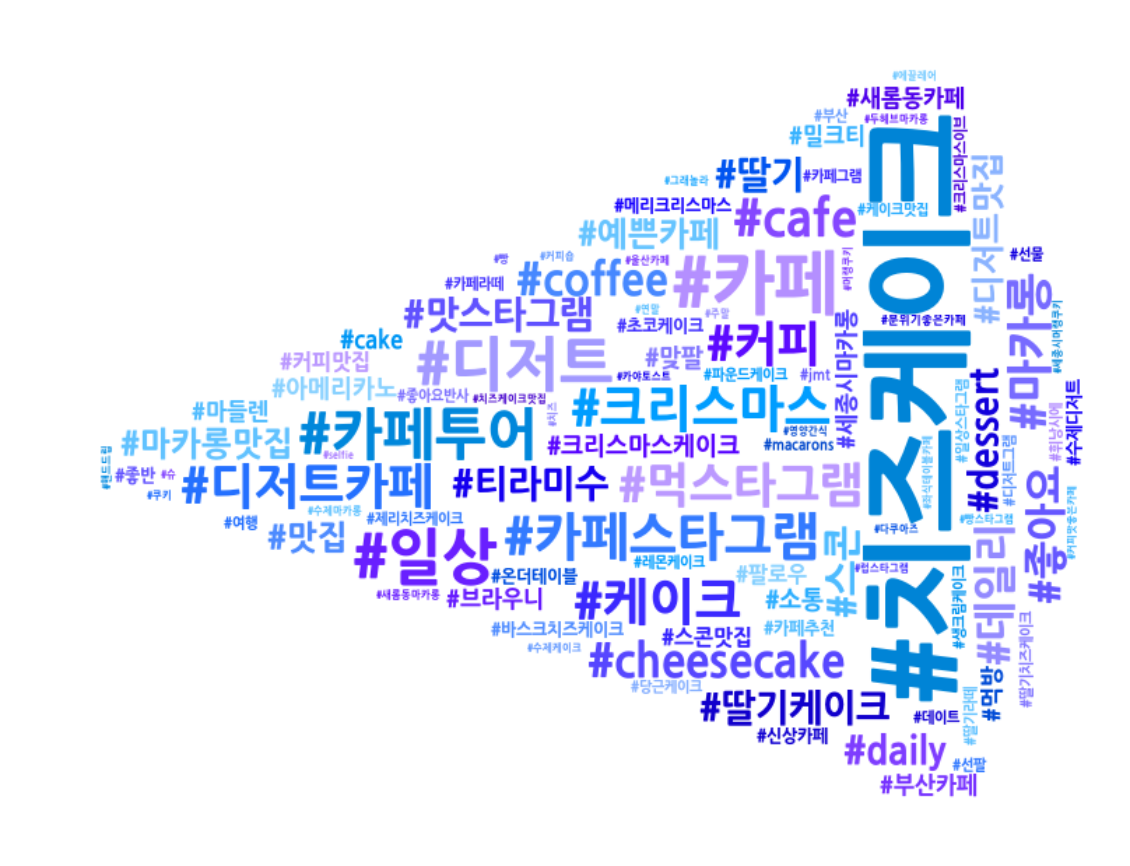

In [61]:
#워드클라우드
import numpy as np
from PIL import Image
from collections import Counter
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

#워드클라우드 모양이 될 외부 png 파일 불러오기
mask = np.array(Image.open('./shape.png')) #png 경로 지정

#컬러 커스터마이징
color_value = [260, 245, 219, 203]
def new_color_func(word, font_size, position,
                   orientation, random_state=None, **kwargs):
    return "hsl(%d,100%%,%d%%)" % (color_value[random.randint(0, 3)],random.randint(40, 80))

#워드클라우드 그리기 (실행할 때마다 구성 조금씩 달라짐)
path = './NanumGothicExtraBold.otf' #한글 폰트 경로 지정하기
wordcloud = WordCloud(font_path=path, max_font_size=80, background_color='white', max_words= 100, mask = mask)
wc = wordcloud.generate_from_frequencies(c)
fig = plt.figure(figsize = (20,20))
plt.imshow(wc.recolor(color_func=new_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.show()

# 7. 보완할 점
* 한계 - 검색량 제한으로 인한 샘플데이터 한계
인스타그램의 검색량 제한으로 인해 최근 데이터만 수집할 수 있었다.  
인스타 검색 시 인기게시물 20여개가 나온 뒤 최근순으로 글이 보이기 때문에  
20여개를 제외하고는 모두 2019년 12월 9일~2019년 12월 31일의 데이터였다.  
따라서 월별 분석을 하기에는 정보가 부족했다



# 8. 프로젝트 느낀점
